# Final Regression Notebook 

Importing packages

In [1]:
import pandas as pd
import numpy as np 
import pickle

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()
%config InlineBackend.figure_formats = ['svg'] 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

Loading pickled dataframe with engineered features

In [2]:
fl_movies_wbudget4 = pd.read_pickle('fl_movies_wbudget4.pickle')

In [3]:
fl_movies_wbudget4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 555 entries, 0 to 560
Data columns (total 35 columns):
 #   Column                                         Non-Null Count  Dtype         
---  ------                                         --------------  -----         
 0   title                                          555 non-null    object        
 1   max_theaters                                   555 non-null    float64       
 2   num_opening_theaters                           555 non-null    float64       
 3   release_date                                   555 non-null    datetime64[ns]
 4   domestic_distributor                           555 non-null    object        
 5   earliest_release_location                      555 non-null    object        
 6   runtime                                        555 non-null    float64       
 7   genres                                         555 non-null    object        
 8   crew                                           555 non-null 

/Users/ceciliabell/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(array([ 2.,  2.,  9., 14., 38., 54., 80., 59., 34.,  9.]),
 array([ 4.48149853,  5.82251885,  7.16353917,  8.50455948,  9.8455798 ,
        11.18660012, 12.52762044, 13.86864076, 15.20966108, 16.55068139,
        17.89170171]),
 <BarContainer object of 10 artists>)

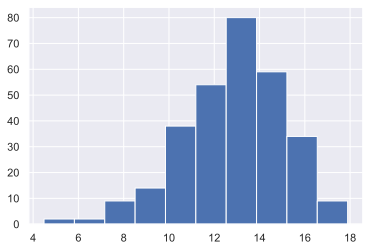

In [4]:
plt.hist(np.log(fl_movies_wbudget4['domestic_total_profit_real']))

In [5]:
minimum_profit = min(fl_movies_wbudget4['domestic_total_profit_real'])
constant_target = []
for profit in fl_movies_wbudget4.domestic_total_profit_real:
    constant_target.append((profit - minimum_profit)+1)

In [6]:
fl_movies_wbudget4['constant_target'] = constant_target

In [7]:
fl_movies_wbudget4.constant_target.describe()

count    5.550000e+02
mean     2.588214e+07
std      5.136154e+06
min      1.000000e+00
25%      2.482796e+07
50%      2.501267e+07
75%      2.560869e+07
max      8.391521e+07
Name: constant_target, dtype: float64

Setting up targets and features

In [8]:
features = ['max_theaters','domestic_opening_real','earliest_release_location_opening_gross_real',
            'earliest_release_location_original_gross_real','international_total_profit_real']
target = 'domestic_total_profit_real'
#target_wconstant = 'constant_target'

Splitting trianing and test data

In [9]:
X = fl_movies_wbudget4.loc[:, features]
y = fl_movies_wbudget4[target]
#y_trans = np.log(fl_movies_wbudget3[target_wconstant])

X, X_test, y, y_test = train_test_split(X, y, test_size=.15, random_state=42)

Splitting training and validation data

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.15, random_state=42)

## Attempt 1: Linear Regression

In [11]:
lr = LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_train,y_train)

0.8742082231742425

In [12]:
lr.score(X_val,y_val)

0.5831595181104725

In [13]:
print(lr.coef_)

[-3.68353420e+02  2.42184573e+00 -2.61150528e+00  8.75238838e-01
  7.35994891e-03]


Text(0.5, 1.0, 'Residuals vs. Predictions')

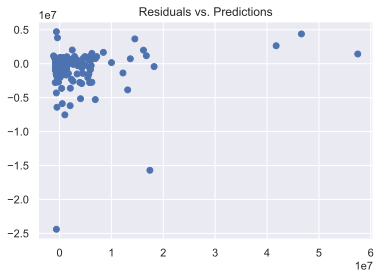

In [14]:
y_train_pred = lr.predict(X_train)
lr_residuals = y_train - y_train_pred

plt.scatter(y_train_pred, lr_residuals)
plt.plot([0,400], [0, 0])
plt.title("Residuals vs. Predictions")

####  Attempt with log transformation of target 

In [26]:
"""features = ['max_theaters','domestic_opening_real','earliest_release_location_opening_gross_real',
            'earliest_release_location_original_gross_real','international_total_profit_real']
#target = 'domestic_total_profit_real'
#target = 'constant_target'

X = fl_movies_wbudget4.loc[:, features]
y = np.log(fl_movies_wbudget4[target])

X, X_test, y, y_test = train_test_split(X, y, test_size=.15, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.15, random_state=42)

lr = LinearRegression()
lr.fit(X_train,y_train)
print(np.exp(lr.score(X_train,y_train)))
print(np.exp(lr.score(X_val,y_val)))"""

1.0253933636344295
1.4383753890715845


Text(0.5, 1.0, 'Residuals vs. Predictions')

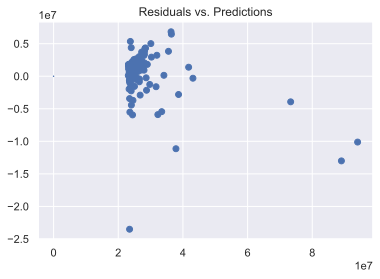

In [27]:
""""y_train_pred = lr.predict(X_train)
lr_residuals = np.exp(y_train) - np.exp(y_train_pred)

plt.scatter(np.exp(y_train_pred), lr_residuals)
plt.plot([0,400], [0, 0])
plt.title("Residuals vs. Predictions")"""

The residuals are still skewed... 

## Attempt 2: Lasso Regression - since the linear model is overfitting 

In [15]:
features = ['max_theaters','domestic_opening_real','earliest_release_location_opening_gross_real',
            'earliest_release_location_original_gross_real','international_total_profit_real']
target = 'domestic_total_profit_real'
#target = 'constant_target'

X = fl_movies_wbudget4.loc[:, features]
y = fl_movies_wbudget4[target]

std = StandardScaler()
std.fit(X_train)

StandardScaler()

In [16]:
X_tr = std.transform(X_train)
X_vl = std.transform(X_val)
lasso_model = Lasso(alpha = 10)
lasso_model.fit(X_tr,y_train)

Lasso(alpha=10)

In [17]:
lasso_model.score(X_tr,y_train)

0.8742082222411488

In [18]:
lasso_model.score(X_vl,y_val)

0.5831583669638105

In [19]:
list(zip(X_train.columns, lasso_model.coef_))

[('max_theaters', -84186.71398968433),
 ('domestic_opening_real', 3271847.2940963283),
 ('earliest_release_location_opening_gross_real', -20117328.476093534),
 ('earliest_release_location_original_gross_real', 20271300.56006059),
 ('international_total_profit_real', 453568.3757131494)]

### Splitting and validating to try different targets

In [20]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 85/15 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.15, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit linear model on validation data
    lr_val_score = lr_model.score(X_val, y_val)
    
    # scaling data 
    std = StandardScaler()
    std.fit(X_train)
    X_tr = std.transform(X_train)
    X_vl = std.transform(X_val)
    
    # fit lasso model to scaled training data 
    lasso_model = Lasso(alpha = 10)
    lasso_model.fit(X_tr,y_train)
    
    # score fit lasso model on validation data
    lasso_val_score = lasso_model.score(X_vl,y_val)
    
    # report results
    print('\nLinear validation R^2 score was:', lr_val_score)
    print('\nLasso validation R^2 score was:', lasso_val_score)
    
    print('Linear feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}') 
        
    print('Lasso feature coefficient results: \n')
    for feature, coef in zip(X.columns, lasso_model.coef_):
        print(feature, ':', f'{coef:.2f}') 

### Adding interaction features 

Double checking that the test and validate function works 

In [21]:
features = ['max_theaters','domestic_opening_real','earliest_release_location_opening_gross_real',
            'earliest_release_location_original_gross_real','international_total_profit_real']
target = 'domestic_total_profit_real'
#target_wconstant = 'constant_target'

In [22]:
X = fl_movies_wbudget4.loc[:, features]
y = fl_movies_wbudget4[target]
X, X_test, y, y_test = train_test_split(X, y, test_size=.15, random_state=42)

In [23]:
split_and_validate(X, y)


Linear validation R^2 score was: 0.5831595181104725

Lasso validation R^2 score was: 0.5831583669638105
Linear feature coefficient results: 

max_theaters : -368.35
domestic_opening_real : 2.42
earliest_release_location_opening_gross_real : -2.61
earliest_release_location_original_gross_real : 0.88
international_total_profit_real : 0.01
Lasso feature coefficient results: 

max_theaters : -84186.71
domestic_opening_real : 3271847.29
earliest_release_location_opening_gross_real : -20117328.48
earliest_release_location_original_gross_real : 20271300.56
international_total_profit_real : 453568.38


#### Test 1 - multiplying max theaters with international total profit

In [25]:
fl_movies_wbudget4['interaction1'] = fl_movies_wbudget4['max_theaters'] * fl_movies_wbudget4['international_total_profit_real']

In [26]:
features = ['max_theaters','domestic_opening_real','earliest_release_location_opening_gross_real',
            'earliest_release_location_original_gross_real','international_total_profit_real', 'interaction1']
target = 'domestic_total_profit_real'
#target_wconstant = 'constant_target'

In [27]:
X = fl_movies_wbudget4.loc[:, features]
y = fl_movies_wbudget4[target]
X, X_test, y, y_test = train_test_split(X, y, test_size=.15, random_state=42)

In [28]:
split_and_validate(X, y)


Linear validation R^2 score was: 0.5964957608811279

Lasso validation R^2 score was: 0.5965013965798118
Linear feature coefficient results: 

max_theaters : -2427.36
domestic_opening_real : 2.30
earliest_release_location_opening_gross_real : -2.45
earliest_release_location_original_gross_real : 0.83
international_total_profit_real : 0.00
interaction1 : 0.00
Lasso feature coefficient results: 

max_theaters : -555839.55
domestic_opening_real : 3103374.65
earliest_release_location_opening_gross_real : -18901039.38
earliest_release_location_original_gross_real : 19138065.11
international_total_profit_real : 148576.87
interaction1 : 950715.91


#### The interaction feature improved the model! 

#### Test 2 - adding categorical dummy features

In [187]:
#fl_movies_wbudget4['international_total_profit_real_poly'] = fl_movies_wbudget4['international_total_profit_real']**2

In [193]:
#fl_movies_wbudget4.drop(columns=['international_total_profit_real_poly'],inplace=True)

In [29]:
features = ['domestic_opening_real','earliest_release_location_opening_gross_real',
            'earliest_release_location_original_gross_real','interaction1','comedy','romance',
            'miramax','sony_pc']
target = 'domestic_total_profit_real'
#target_wconstant = 'constant_target'

In [30]:
X = fl_movies_wbudget4.loc[:, features]
y = fl_movies_wbudget4[target]
X, X_test, y, y_test = train_test_split(X, y, test_size=.15, random_state=42)

In [31]:
split_and_validate(X, y)


Linear validation R^2 score was: 0.6060085199162222

Lasso validation R^2 score was: 0.6060087492242328
Linear feature coefficient results: 

domestic_opening_real : 2.08
earliest_release_location_opening_gross_real : -2.27
earliest_release_location_original_gross_real : 0.77
interaction1 : 0.00
comedy : 230844.80
romance : 185059.25
miramax : 1741593.17
sony_pc : -95984.50
Lasso feature coefficient results: 

domestic_opening_real : 2808565.50
earliest_release_location_opening_gross_real : -17496325.30
earliest_release_location_original_gross_real : 17764955.14
interaction1 : 829996.46
comedy : 107222.69
romance : 81916.28
miramax : 243874.46
sony_pc : -29995.07


#### Improved the model!!!

#### Test 3 - dropping features 

In [32]:
features = ['domestic_opening_real','interaction1',
            'comedy','drama','romance','action','thriller',
            'miramax','sony_pc']
target = 'domestic_total_profit_real'
X = fl_movies_wbudget4.loc[:, features]
y = fl_movies_wbudget4[target]
X, X_test, y, y_test = train_test_split(X, y, test_size=.15, random_state=42)
split_and_validate(X, y)


Linear validation R^2 score was: 0.3088779239328384

Lasso validation R^2 score was: 0.3088796625108662
Linear feature coefficient results: 

domestic_opening_real : 0.97
interaction1 : 0.00
comedy : 332548.96
drama : 147720.49
romance : 286027.70
action : -1082723.99
thriller : 534954.31
miramax : 7808998.71
sony_pc : 1126036.46
Lasso feature coefficient results: 

domestic_opening_real : 1308740.50
interaction1 : 3334770.11
comedy : 154458.85
drama : 60417.15
romance : 126605.09
action : -457361.20
thriller : 212953.73
miramax : 1093252.00
sony_pc : 352315.61


#### Did not improve the model :( 

## Cross-validating Linear and Lasso models (and Ridge just in case)

### Creating a function to test and cross-validate Linear, Ridge and Lasso models

In [33]:
def kfold_split_and_validate(X, y):
    
    #this helps with the way kf will generate indices below
    X, y = np.array(X), np.array(y)
    
    #run the CV
    kf = KFold(n_splits=5, shuffle=True, random_state = 71)
    cv_lm_r2s, cv_lm_reg_r2s, cv_lm_lasso_r2s = [], [], [] #collect the validation results for both models

    for train_ind, val_ind in kf.split(X,y):
    
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 
    
        #simple linear regression
        lm = LinearRegression()

        lm.fit(X_train, y_train)
        cv_lm_r2s.append(lm.score(X_val, y_val))
    
        #ridge with feature scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
    
        lm_reg = Ridge(alpha=1)
        lm_reg.fit(X_train_scaled, y_train)
        cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))
    
        #lasso with feature scaling
        lm_lasso = Lasso(alpha =1)
        lm_lasso.fit(X_train_scaled, y_train)
        cv_lm_lasso_r2s.append(lm_lasso.score(X_val_scaled, y_val))

    print('Simple regression scores: ', cv_lm_r2s)
    print('Ridge scores: ', cv_lm_reg_r2s, '\n')
    print('Lasso scores: ', cv_lm_lasso_r2s, '\n')

    print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
    print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')
    print(f'Lasso mean cv r^2: {np.mean(cv_lm_lasso_r2s):.3f} +- {np.std(cv_lm_lasso_r2s):.3f}')

### Attempt 1 - the best model with simple test and validation

In [34]:
features = ['domestic_opening_real','earliest_release_location_opening_gross_real',
            'earliest_release_location_original_gross_real','interaction1','comedy','romance',
            'miramax','sony_pc']
target = 'domestic_total_profit_real'

X = fl_movies_wbudget4.loc[:, features]
y = fl_movies_wbudget4[target]

X, X_test, y, y_test = train_test_split(X, y, test_size=.15, random_state=42)

kfold_split_and_validate(X, y)

Simple regression scores:  [-105.44286518186054, 0.44938470701420385, 0.7440964628743695, 0.9464941932762279, 0.8423171268616596]
Ridge scores:  [-182.78631610287678, 0.4479843643942655, 0.6738733664224399, 0.8706010573937903, 0.8370878472978339] 

Lasso scores:  [-160.64410330169952, 0.4493856810568795, 0.7440951988316662, 0.9464677661721927, 0.8423170549073505] 

Simple mean cv r^2: -20.492 +- 42.476
Ridge mean cv r^2: -35.991 +- 73.398
Lasso mean cv r^2: -31.532 +- 64.556


/Users/ceciliabell/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 633958274934997.6, tolerance: 1140010869361.6897
  model = cd_fast.enet_coordinate_descent(
/Users/ceciliabell/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5528205030639.5, tolerance: 1092404048115.9154
  model = cd_fast.enet_coordinate_descent(
/Users/ceciliabell/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 659606141114124.2, tolerance: 657638137067.534
  model = cd_fast.enet_coordinate_descent(


### The best model with simple test and validation was probably overfitting... 

### Attempt 2 - removing features

In [35]:
features = ['domestic_opening_real','interaction1','comedy','drama','romance','thriller','action',
            'earliest_release_location_original_gross_real', 'miramax','sony_pc','apac_china','germany']
target = 'domestic_total_profit_real'

In [36]:
X = fl_movies_wbudget4.loc[:, features]
y = fl_movies_wbudget4[target]

X, X_test, y, y_test = train_test_split(X, y, test_size=.15, random_state=42)

In [37]:
kfold_split_and_validate(X, y)

Simple regression scores:  [-223.93582897213892, -0.021962409949551676, 0.23416175629137514, 0.6552665051302131, 0.7931453439306849]
Ridge scores:  [-219.19949709448915, -0.016253924487202198, 0.23514662424617394, 0.654912006658602, 0.7931928638697968] 

Lasso scores:  [-223.93555242191985, -0.021960703869555953, 0.23416232116207536, 0.6552662457964405, 0.7931453789075897] 

Simple mean cv r^2: -44.455 +- 89.741
Ridge mean cv r^2: -43.506 +- 87.847
Lasso mean cv r^2: -44.455 +- 89.741


### Attempt 3 - removing earliest_release_location_original_gross_real, apac_china, germany

In [38]:
features = ['domestic_opening_real','interaction1',
            'comedy','drama','romance','action','thriller',
            'miramax','sony_pc']
target = 'domestic_total_profit_real'

X = fl_movies_wbudget4.loc[:, features]
y = fl_movies_wbudget4[target]

X, X_test, y, y_test = train_test_split(X, y, test_size=.15, random_state=42)

kfold_split_and_validate(X, y)

Simple regression scores:  [0.44076290318935907, 0.09492233205757228, 0.22977638254549748, 0.6475649795157544, 0.7909639555199555]
Ridge scores:  [0.4411732384043463, 0.0964511584733333, 0.23106482128482597, 0.6472668155804915, 0.7910653384059728] 

Lasso scores:  [0.4407633399962311, 0.09492265827434387, 0.22977682631600738, 0.6475647671595401, 0.7909640228341097] 

Simple mean cv r^2: 0.441 +- 0.257
Ridge mean cv r^2: 0.441 +- 0.256
Lasso mean cv r^2: 0.441 +- 0.257


### Attempt 4 (removed earliest_release_location_original_gross_real, removed apac_china, removed germany)

In [39]:
features = ['domestic_opening_real',
            'comedy','drama','romance','action','thriller',
            'miramax','sony_pc']
target = 'domestic_total_profit_real'

X = fl_movies_wbudget4.loc[:, features]
y = fl_movies_wbudget4[target]

X, X_test, y, y_test = train_test_split(X, y, test_size=.15, random_state=42)

kfold_split_and_validate(X, y)

Simple regression scores:  [0.006405298053752118, 0.01993035375284924, -0.15273042204020126, 0.08978188494648576, 0.7425755342607143]
Ridge scores:  [0.007393397035481031, 0.021248372752587064, -0.1521801398625322, 0.09004755864747549, 0.7423758225951398] 

Lasso scores:  [0.006406009558186376, 0.01993110875316184, -0.15273004542708657, 0.08978172210187563, 0.7425754741164661] 

Simple mean cv r^2: 0.141 +- 0.311
Ridge mean cv r^2: 0.142 +- 0.311
Lasso mean cv r^2: 0.141 +- 0.311


#### The model does not get any better... go with Ridge regression attempt 3 and choose the best alpha

### Choosing the best alpha for Ridge regression

In [51]:
features = ['domestic_opening_real','interaction1',
            'comedy','drama','romance','action','thriller',
            'miramax','sony_pc']
target = 'domestic_total_profit_real'

X = fl_movies_wbudget4.loc[:, features]
y = fl_movies_wbudget4[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15, random_state=42)

std = StandardScaler()
std.fit(X_train)

X_train_scaled = std.transform(X_train)
X_test_scaled = std.transform(X_test)

alphavec = 10**np.linspace(-2,2,200)

lm_reg = RidgeCV(alphas = alphavec, cv=5)
lm_reg.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [52]:
lm_reg.alpha_

43.470131581250264

## Evaluating the chosen model  

### Ridge regression with the following features: 
#### 'domestic_opening_real','interaction1', 'comedy','drama','romance','action','thriller', 'miramax','sony_pc'
interaction1: multiplying max theaters with international total profit

In [53]:
features = ['domestic_opening_real','interaction1',
            'comedy','drama','romance','action','thriller',
            'miramax','sony_pc']
target = 'domestic_total_profit_real'
#target_wconstant = 'constant_target'

X = fl_movies_wbudget4.loc[:, features]
y = fl_movies_wbudget4[target]
#y = np.log(fl_movies_wbudget4[target_wconstant])

X, X_test, y, y_test = train_test_split(X, y, test_size=.15, random_state=42)

X, y = np.array(X), np.array(y)
    
#run the CV
kf = KFold(n_splits=5, shuffle=True, random_state = 71)

cv_lm_reg_train_r2s, cv_lm_reg_val_r2s, cv_lm_reg_pred_r2s = [], [], []

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
     
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    lm_reg = Ridge(alpha=0.01)
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_train_r2s.append(lm_reg.score(X_train_scaled, y_train))
    cv_lm_reg_val_r2s.append(lm_reg.score(X_val_scaled, y_val))
    cv_lm_reg_pred_r2s.append(lm_reg.score(X_test_scaled, y_test))
    
print('Ridge train scores: ', cv_lm_reg_train_r2s, '\n')   
print(f'Ridge mean train r^2: {np.mean(cv_lm_reg_train_r2s):.3f} +- {np.std(cv_lm_reg_train_r2s):.3f}')
print('Ridge cval scores: ', cv_lm_reg_val_r2s, '\n')
print(f'Ridge mean cval r^2: {np.mean(cv_lm_reg_val_r2s):.3f} +- {np.std(cv_lm_reg_val_r2s):.3f}')
print('Ridge pred scores: ', cv_lm_reg_pred_r2s, '\n')
print(f'Ridge mean pred r^2: {np.mean(cv_lm_reg_pred_r2s):.3f} +- {np.std(cv_lm_reg_pred_r2s):.3f}')

Ridge train scores:  [0.6986769536036975, 0.703588607080157, 0.7276391799852195, 0.6801254563553512, 0.6242611574331145] 

Ridge mean train r^2: 0.687 +- 0.035
Ridge cval scores:  [0.4407670491051453, 0.09493771722688471, 0.22978936348633017, 0.6475620133543583, 0.7909650022425669] 

Ridge mean cval r^2: 0.441 +- 0.257
Ridge pred scores:  [0.18716839865676704, 0.20527059990701513, 0.18012998046193684, 0.2114856463729059, 0.1924825413752268] 

Ridge mean pred r^2: 0.195 +- 0.012


#### Looking at training data vs predicted training data 

(-10000000.0, 40000000.0)

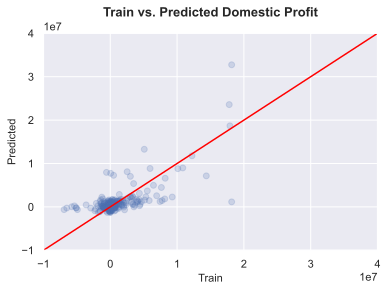

In [54]:
# Fitted vs. Actual
y_train_pred = lm_reg.predict(X_train_scaled)

plt.scatter(y_train, y_train_pred, alpha=0.2)
#plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_test_pred, 1))(np.unique(y_test)), color='yellow')
plt.plot([-1e7,4e7], [-1e7,4e7], c="red")
plt.xlabel("Train", fontsize=11)
plt.ylabel("Predicted", fontsize=11)
plt.title("Train vs. Predicted Domestic Profit", weight='bold', fontsize=13, y=1.05)
axes = plt.gca()
axes.set_ylim([-1e7,4e7])
axes.set_xlim([-1e7,4e7])
#plt.savefig('train_predicted_domestic_profit', bbox_inches='tight')

### Looking at R^2 score for test data 

In [301]:
lm_reg.score(X_test_scaled, y_test)

0.1924825413752268

In [307]:
print(f'Ridge pred r^2: {lm_reg.score(X_test_scaled, y_test):.3f} +- {np.std(lm_reg.score(X_test_scaled, y_test)):.3f}')

Ridge pred r^2: 0.192 +- 0.000


### Looking at test data vs predicted test data

(-10000000.0, 40000000.0)

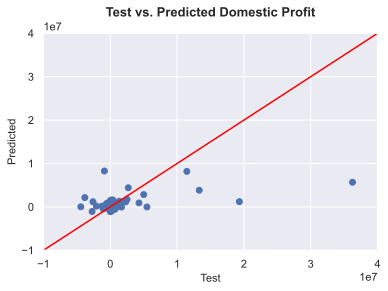

In [321]:
# Fitted vs. Actual
y_test_pred = lm_reg.predict(X_test_scaled)

plt.scatter(y_test, y_test_pred)
#plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_test_pred, 1))(np.unique(y_test)), color='yellow')
plt.plot([-1e7,4e7], [-1e7,4e7], c="red")
plt.xlabel("Test", fontsize=11)
plt.ylabel("Predicted", fontsize=11)
plt.title("Test vs. Predicted Domestic Profit", weight='bold', fontsize=13, y=1.05)
axes = plt.gca()
axes.set_ylim([-1e7,4e7])
axes.set_xlim([-1e7,4e7])
#plt.savefig('test_predicted_domestic_profit', bbox_inches='tight')

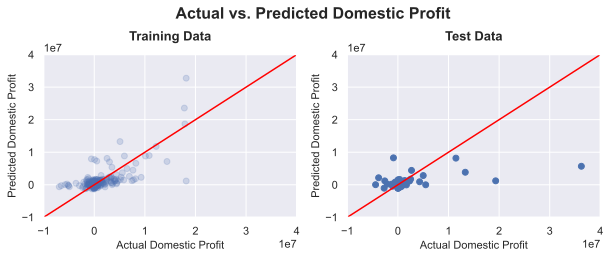

In [326]:
plt.figure(figsize=[10,3])
plt.suptitle('Actual vs. Predicted Domestic Profit',fontsize = 16, weight='bold', y=1.1)

plt.subplot(1,2,1) # (number of rows, number of columns, number of plot)
plt.scatter(y_train, y_train_pred, alpha=0.2)
plt.plot([-1e7,4e7], [-1e7,4e7], c="red")
plt.xlabel("Actual Domestic Profit", fontsize=11)
plt.ylabel("Predicted Domestic Profit", fontsize=11)
plt.title("Training Data", weight='bold', fontsize=13, y=1.05)
axes = plt.gca()
axes.set_ylim([-1e7,4e7])
axes.set_xlim([-1e7,4e7])

plt.subplot(1,2,2)
plt.scatter(y_test, y_test_pred)
plt.plot([-1e7,4e7], [-1e7,4e7], c="red")
plt.xlabel("Actual Domestic Profit", fontsize=11)
plt.ylabel("Predicted Domestic Profit", fontsize=11)
plt.title("Test Data", weight='bold', fontsize=13, y=1.05)
axes = plt.gca()
axes.set_ylim([-1e7,4e7])
axes.set_xlim([-1e7,4e7])

plt.savefig('actual_predicted_domestic_profit.svg', bbox_inches='tight')
plt.show();

Text(0.5, 1.0, 'Residuals vs. Predictions')

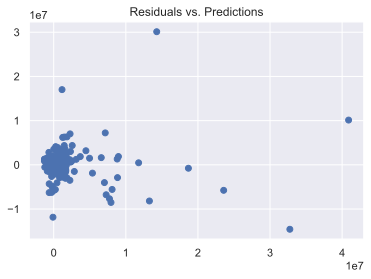

In [305]:
# Plot Residuals vs. predicted

lm_reg_residuals = y_train - y_train_pred

plt.scatter(y_train_pred, lm_reg_residuals)
plt.plot([0,400], [0, 0])
plt.title("Residuals vs. Predictions")

Text(0.5, 1.0, 'Residuals vs. Predictions')

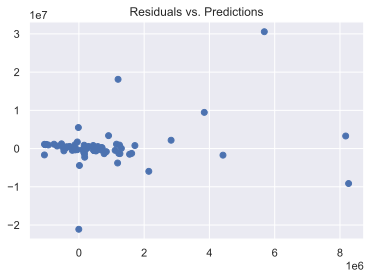

In [306]:
# Plot Residuals vs. predicted

lm_reg_residuals2 = y_test - y_test_pred

plt.scatter(y_test_pred, lm_reg_residuals2)
plt.plot([0,400], [0, 0])
plt.title("Residuals vs. Predictions")

In [308]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = mean_squared_error(y_test, y_test_pred, squared=False)
mae = mean_absolute_error(y_test, y_test_pred)
print(rmse)
print(mae)

4945372.145804833
1917993.440203068


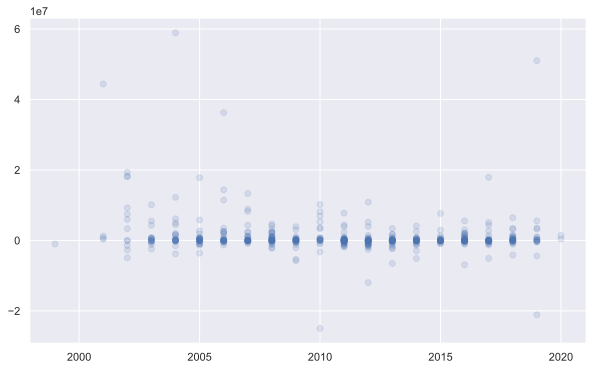

In [310]:
plt.figure(figsize=(10,6))
plt.scatter(fl_movies_wbudget4['year'],fl_movies_wbudget4['domestic_total_profit_real'], alpha=0.15)

In [357]:
features = ['domestic_opening_real','interaction1',
            'comedy','drama','romance','action','thriller',
            'miramax','sony_pc']
#target = 'domestic_total_profit_real'
target_wconstant = 'constant_target'

X = fl_movies_wbudget4.loc[:, features]
#y = fl_movies_wbudget4[target]
y = np.log(fl_movies_wbudget4[target_wconstant])

X, X_test, y, y_test = train_test_split(X, y, test_size=.15, random_state=42)

X, y = np.array(X), np.array(y)
    
#run the CV
kf = KFold(n_splits=5, shuffle=True, random_state = 71)

cv_lm_reg_train_r2s, cv_lm_reg_val_r2s, cv_lm_reg_pred_r2s = [], [], []

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
     
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    lm_reg = Ridge(alpha=0.01)
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_train_r2s.append(np.exp(lm_reg.score(X_train_scaled, y_train)))
    cv_lm_reg_val_r2s.append(np.exp(lm_reg.score(X_val_scaled, y_val)))
    cv_lm_reg_pred_r2s.append(np.exp(lm_reg.score(X_test_scaled, y_test)))
    
print('Ridge train scores: ', cv_lm_reg_train_r2s, '\n')   
print(f'Ridge mean train r^2: {np.mean(cv_lm_reg_train_r2s):.3f} +- {np.std(cv_lm_reg_train_r2s):.3f}')
print('Ridge cval scores: ', cv_lm_reg_val_r2s, '\n')
print(f'Ridge mean cval r^2: {np.mean(cv_lm_reg_val_r2s):.3f} +- {np.std(cv_lm_reg_val_r2s):.3f}')
print('Ridge pred scores: ', cv_lm_reg_pred_r2s, '\n')
print(f'Ridge mean pred r^2: {np.mean(cv_lm_reg_pred_r2s):.3f} +- {np.std(cv_lm_reg_pred_r2s):.3f}')

Ridge train scores:  [1.0412878867837312, 1.0397746128414418, 1.0389367661495539, 1.0300173441565386, 1.730610428135192] 

Ridge mean train r^2: 1.176 +- 0.277
Ridge cval scores:  [0.06063284847098493, 0.06773173619482185, 0.4211907086638955, 1.3439042293349917, 0.9976603422168859] 

Ridge mean cval r^2: 0.578 +- 0.513
Ridge pred scores:  [0.8383035723571969, 0.8990473538583748, 0.8859054880647663, 0.9244265556800142, 1.082457339931894] 

Ridge mean pred r^2: 0.926 +- 0.083


(10000000.0, 50000000.0)

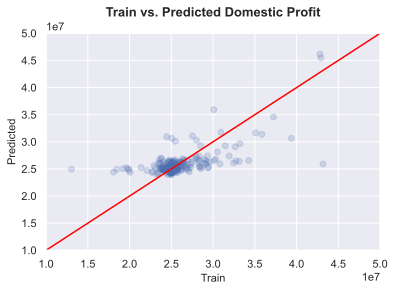

In [363]:
# Fitted vs. Actual
y_train_pred = lm_reg.predict(X_train_scaled)

plt.scatter(np.exp(y_train), np.exp(y_train_pred), alpha=0.2)
#plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_test_pred, 1))(np.unique(y_test)), color='yellow')
plt.plot([1e7,5e7], [1e7,5e7], c="red")
plt.xlabel("Train", fontsize=11)
plt.ylabel("Predicted", fontsize=11)
plt.title("Train vs. Predicted Domestic Profit", weight='bold', fontsize=13, y=1.05)
axes = plt.gca()
axes.set_ylim([1e7,5e7])
axes.set_xlim([1e7,5e7])
#plt.savefig('train_predicted_domestic_profit', bbox_inches='tight')

In [55]:
fl_movies_wbudget4.domestic_total_profit_real.describe()

count    5.550000e+02
mean     8.875514e+05
std      5.136154e+06
min     -2.499459e+07
25%     -1.666294e+05
50%      1.808271e+04
75%      6.141044e+05
max      5.892062e+07
Name: domestic_total_profit_real, dtype: float64

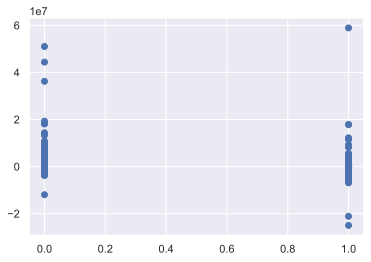

In [60]:
plt.scatter(fl_movies_wbudget4., fl_movies_wbudget4.domestic_total_profit_real)

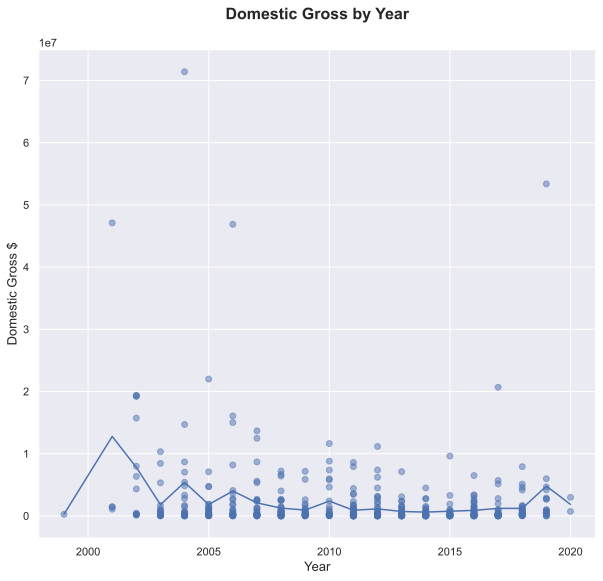

In [98]:
plt.figure(figsize=[10,9])
df_mean = fl_movies_wbudget4.groupby('year')['domestic_total_gross_real'].mean()
plt.plot(df_mean.index, df_mean)
plt.xlabel("Year", fontsize=13)
plt.ylabel("Domestic Gross $", fontsize=13)
plt.title("Domestic Gross by Year", weight='bold', fontsize=16, y=1.05)
plt.scatter(fl_movies_wbudget4.year, fl_movies_wbudget4.domestic_total_gross_real, alpha=0.5)

#plt.savefig('domestic_gross_year.svg', bbox_inches='tight')

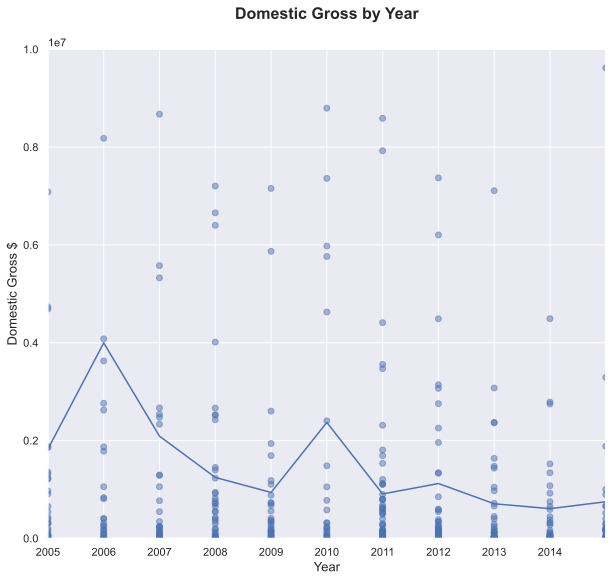

In [99]:
plt.figure(figsize=[10,9])
df_mean = fl_movies_wbudget4.groupby('year')['domestic_total_gross_real'].mean()
plt.plot(df_mean.index, df_mean)
plt.xlabel("Year", fontsize=13)
plt.ylabel("Domestic Gross $", fontsize=13)
plt.title("Domestic Gross by Year", weight='bold', fontsize=16, y=1.05)
plt.xticks(np.arange(2005, 2015, 1))
axes = plt.gca()
axes.set_xlim([2005,2015])
axes.set_ylim([0,1e7])

plt.scatter(fl_movies_wbudget4.year, fl_movies_wbudget4.domestic_total_gross_real, alpha=0.5)

#plt.savefig('domestic_gross_year2.svg', bbox_inches='tight')

In [100]:
max(fl_movies_wbudget4['domestic_total_gross_real'])

71397362.31356801